__Experiments__ <br>
This is the notebook in which samplers are run, their performance measured and their results compared to all other samplers in this project. One of five samplers below is chosen for a run
* Adaptive Metropolis: *AM*
* Covariance Matrix Adaptation: *CMA*
* Gaussian Adaptation: *GaA*
* Metropolis Hastings: *MH*
* Adaptive MH using Cholesky decomposition of the covariance: *L_MH*

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as ss
import math
import random
import numba
from collections import namedtuple

In [2]:
plt.style.use('classic') #'seaborn-whitegrid'
sns.set()
%precision 4
%matplotlib inline
# To reload modules
import importlib

In [3]:
from FileHandling import save_state, inspect_state, save_run_data, save_comparison

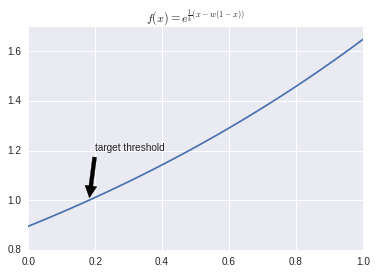

In [4]:
from MH_Sampling import acceptance_decision, MH_sampler, L_MH_sampler, init_MH_pars
#from SG_MH_Sampling import SG_MH_sampler, init_SG_MH_pars
from AM_Sampling import AM_sampler, init_AM_pars
from CMA_Sampling import CMA_sampler, init_CMA_pars
from GaA_Sampling import C_GaA_sampler, Q_GaA_sampler, init_GaA_pars

In [5]:
from TestSuite import generate_state_space, generate_iid_samples, \
    generate_initial_states, generate_Gaussian, get_distribution, get_samples

# The Samplers

In [6]:
SAMPLERS = {'MH':dict(Name='MH', Function=MH_sampler, 
                      InitParameters=init_MH_pars, 
                      Color='red'),
            'L_MH':dict(Name='L_MH', Function=L_MH_sampler, 
                        InitParameters=init_MH_pars, 
                        Color='brown'),
            'AM':dict(Name='AM', 
                      Function=AM_sampler, 
                      InitParameters=init_AM_pars, 
                      Color='blue'),
            'CMA':dict(Name='CMA', 
                       Function=CMA_sampler, 
                       InitParameters=init_CMA_pars, 
                       Color='green'),
            'GaA':dict(Name='GaA', 
                       Function=Q_GaA_sampler, 
                       InitParameters=init_GaA_pars,
                       Color='yellow')}

#'SG_MH':dict(Name='SG_MH', Function=SG_MH_sampler, InitParameters=init_SG_MH_pars, Color='black')

In [7]:
def get_sampler(name):
    global SAMPLERS
    return SAMPLERS[name]

In [8]:
def create_data_store(dim, N):
    return dict(States=np.zeros(shape=(N, dim)),
                Densities=np.zeros(N), 
                Accepted_p=np.zeros(N, dtype=bool),
                Means=np.zeros(shape=(N, dim)),
                # Covariance matrix or its Cholesky decomposition or square root
                Covariances=np.zeros((N, dim, dim)), 
                # The parameter r in Gaussian Adaption or sigma in CMA-ES is stored in
                Scales=np.zeros(N), 
                # The parameter theta in Gaussian Adaption is stored in
                Thresholds=np.zeros(N), 
                # Done is false when created and becomes true when the run is finished
                Done=False,
                # ChainLength is 0 when created and is set to the effective chain length
                # when the run is finished.
                ChainLength=0)

# Run *Specification*

A **run** is specified by the
   * state space **sp**, 
   * number of samples **N** we want to generate, 
   * **name** of the **target distribution**, and 
   * **sampler's name**, 
   * **index** of that run.

In [9]:
RunData = namedtuple('RunData',
                     ['StateSpace', 'N', 'Target', 'Sampler', 'RunIdx', 'DataStore'])

In [10]:
def specify_run(dim, N, name_target, name_sampler, run_idx):
    sp = generate_state_space(dim=dim)
    generate_iid_samples(sp=sp, N=N)
    target = get_distribution(sp=sp, name=name_target)
    sampler = get_sampler(name=name_sampler)
    data_store = create_data_store(dim=dim, N=N)
    return RunData(StateSpace=sp, 
                   N=N, 
                   Target=target, 
                   Sampler=sampler, 
                   RunIdx=run_idx, 
                   DataStore=data_store)

In [11]:
def get_states(run_data):
    return run_data.DataStore['States']

def get_contour_function_and_levels(run_data):
    target = run_data.Target
    return target['Contour Function'], target['Contour Levels']

# Run *Execution*

In [12]:
def execute_run(run_data):
    sp, sampler, N, run_idx = \
        run_data.StateSpace, run_data.Sampler, run_data.N, run_data.RunIdx
    initial_states = sp['Initial States']
    return sampler['Function'](pars=sampler['InitParameters'](sp=sp),
                               target=run_data.Target, 
                               initial_state=initial_states[run_idx], 
                               run_data=run_data)

## This is how you execute a run

### Specification

   * Specify the dimension of the state space, i.e. the value of the parameter *dim*
   * Specify the total number $N$ of samples to be generated
   * Give the name of the target, i.e. the value of the parameter *name_target*
   * Give the name of the sampler, i.e. the value of the parameter *name_sampler*
   * The argument *run_idx* refers to the index of this run
   
### Execution
   * Execute a run using the given specification. It returns a datastore that contains all data related to that run
   and is used in the visualization of that run.

In [13]:
# specify dimensions 'dim', choose sampler 'name_sampler', choose target distribution 'namme_target'
SPEC = specify_run(dim=2, N=10000, name_target='Pi_4', name_sampler='CMA', run_idx=0)
DATA = execute_run(SPEC)

# Visualization of a run

In [14]:
from Visualization import GRID, plot_samples, compare_to_iid_samples, plot_contour_lines, compare_sample_spread

Burn in used is 50 percent of the generated samples.
CMA Fractions: 0.04720, 0.07640, 0.08680, and 0.11100
IID Fractions: 0.05240, 0.09240, 0.11000, and 0.14720


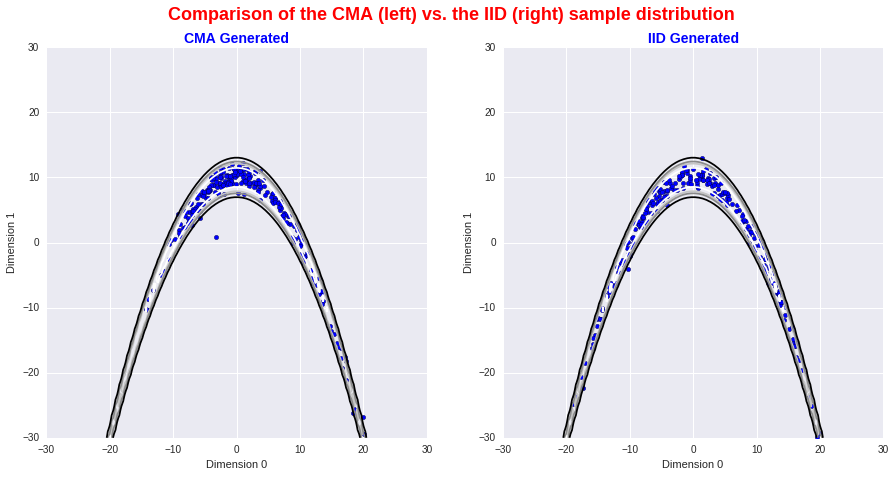

In [15]:
compare_to_iid_samples(run_data=DATA, dim1=0, dim2=1, nb_samples=250, burnin_pct=50)

# Time to Test

New we compare two different implementations of Metropolis-Hastings: one that uses the covariance matrix $C$ to generate the candidates and one that uses the Cholesky factor $L$  to genereate the candidates.
The results should be similar when visualized.

In [16]:
def test_L_variant(dim, N, name_target, name_sampler, run_idx=0):
    '''Compares the C- and L-variant of the sampler named s_name on target with name t_name.
    dim is the dimension of the state space and N is the number of samples generated.'''
    # Specify the run for both variants.
    sampler_spec = specify_run(dim, N, name_target, name_sampler, run_idx)
    l_sampler_spec = specify_run(dim, N, name_target, 'L_'+name_sampler, run_idx)
    
    #Execute with the given specifications
    sampler_data, l_sampler_data = execute_run(sampler_spec), execute_run(l_sampler_spec)
    
    #Get the samples
    samples, l_samples = sampler_data.DataStore['States'], l_sampler_data.DataStore['States']
    return sampler_data, l_sampler_data

In [17]:
MH_DATA, L_MH_DATA = test_L_variant(dim=10, N=10000, name_target='Pi_1', name_sampler='MH')

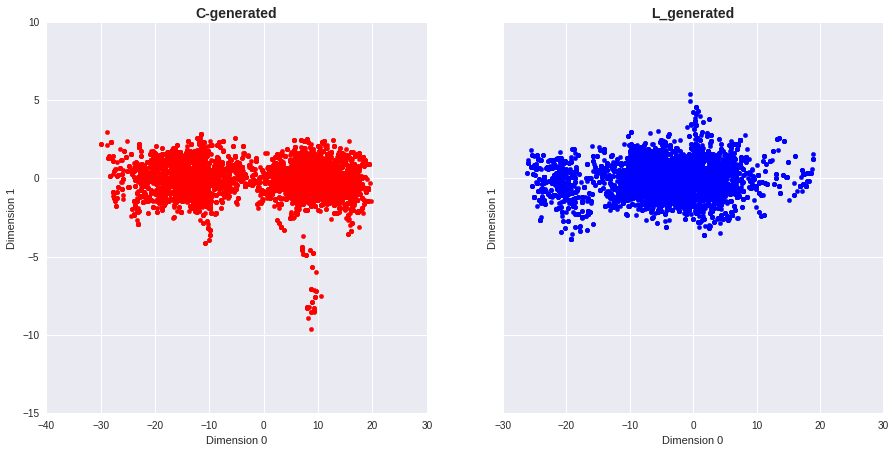

In [18]:
compare_sample_spread(dim1=0, dim2=1, 
                      list_of_samples=[get_states(MH_DATA), get_states(L_MH_DATA)],
                      colors=['red', 'blue'], titles=['C-generated', 'L_generated'])

## Plot MCMC samples and compare them to i.i.d samples

Burn in used is 50 percent of the generated samples.
MH Fractions: 0.00060, 0.06340, 0.14620, and 0.44640
IID Fractions: 0.00540, 0.07920, 0.18960, and 0.48640


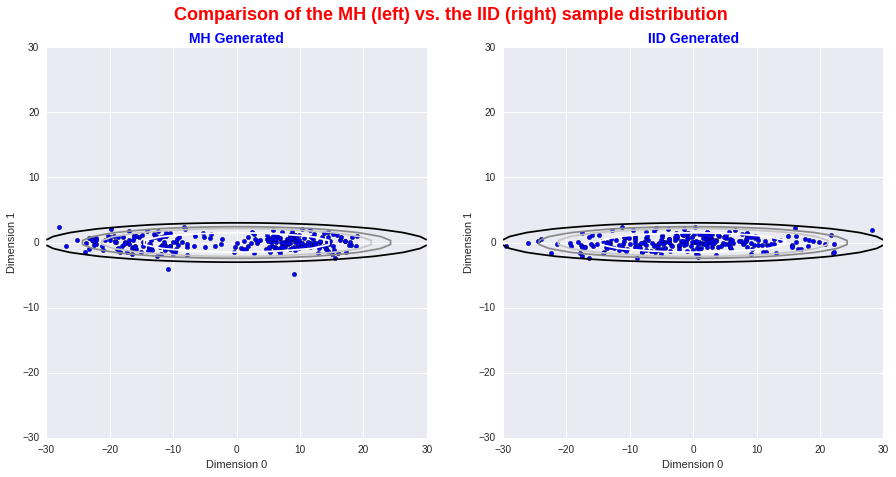

In [19]:
compare_to_iid_samples(run_data=MH_DATA, dim1=0, dim2=1, nb_samples=250, burnin_pct=50)

In [20]:
def heath_map(run_data, dim1=0, dim2=1):
    global GRID
    states = run_data.DataStore['States']
    x_components, y_components = states[:,dim1], states[:,dim2]
    contour_function, levels = get_contour_function_and_levels(run_data)
    X, Y = GRID.X, GRID.Y
    Z = contour_function(X, Y)
    plt.hexbin(x_components, y_components, bins=15, cmap='Blues')
    cb = plt.colorbar()
    cb.set_label('counts in bins');
    plt.contour(X, Y, Z, levels)

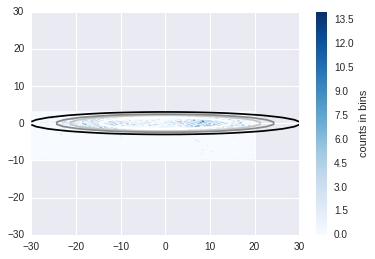

In [21]:
heath_map(MH_DATA)

# Plot several *traces*

The following **traces** are plotted

   1. target values, 
   2. acceptance ratio
   3. trace of one of the components of the state, and 
   4. in the future, the condition number of the 'covariances'

In [22]:
import numba

In [23]:
@numba.jit
def Euclidean_distance(x_1, x_2):
    return np.sqrt(np.sum((x_1 - x_2)**2))

In [24]:
def get_life_data(run_data):
    ds = run_data.DataStore
    return ds['States'], ds['Densities'], ds['Accepted_p'], ds['Covariances']

In [25]:
def running_avg(seq):
    return np.cumsum(seq)/np.arange(1, len(seq)+1)

In [26]:
def plot_traces(run_data, dim=0, resolution=1, start=0, stop=None, step=1):
    # The information to visualize
    ds = run_data.DataStore
    states, values, accepted_p, covariances = get_life_data(run_data)
    #fig, axes = plt.subplots(2, 2, sharex=True)
    #fig = plt.figure(figsize=(40, 40))
    #fig.subplots_adjust(hspace=10.0)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(9, 6))
    
    ax1.plot(values[start:stop:step])
    ax1.set_title('The value of the target distribution.')
    ax1.set_ylabel('$\pi(x)$')
    
    ax2.plot(running_avg(accepted_p)[start:stop:step])
    ax2.set_title('Acceptance Ratio')
    ax2.set_ylabel('$\pi(x)$')
    
    ax3.plot(states[start:stop:step, dim])
    ax3.set_title('Trace')
    ax3.set_ylabel('$x_{}$'.format(dim))
    
    #ax4.plot(la.cond(covariances)[start:stop:step])
    ax4.set_title('Condition number $\kappa$')
    ax4.set_ylabel('$\kappa(C)$')
    
    fig.subplots_adjust(left=0.125, right=0.9, bottom=0.1,
                        top=0.9, wspace=0.2, hspace=0.2)
    
    #fig.tight_layout()

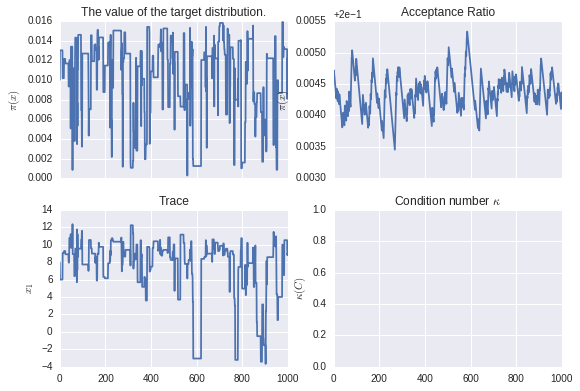

In [27]:
plot_traces(run_data=DATA, start=5000, stop=6000, dim=1)

# Next we can *compare all samplers*

In [28]:
def compare_samplers(name_target, dim, N, run_idx=0):
    global SAMPLERS
    data = []
    for name_sampler, sampler in SAMPLERS.items():
        dim, N, name_target, name_sampler, run_idx
        run_data = specify_run(dim, N, name_target, name_sampler, run_idx)
        data.append(execute_run(run_data))
    return data

In [29]:
def plot_comparison(samplers_data):
    [plot_samples(run_data=data, nb_samples=100, dim1=0, dim2=1, burnin_pct=50) 
     for data in combined_data]

In [30]:
SAMPLERS_DATA = compare_samplers(name_target='Pi_4', dim=2, N=10000)

# Compare the *autocorrelation* functions

In [31]:
def autocorrelation(series, max_lag=1000):
    x = series - np.mean(series)
    xnorm = np.sum(x**2)
    autocor = np.correlate(x, x, "same")/xnorm 
    # use only second half 
    origin = int(np.floor(len(autocor)/2))
    return autocor[origin:origin+max_lag]

In [32]:
def plot_autocorrelation(autocorrelations, color, label):
    plt.plot(autocorrelations, color=color, label=label)

In [33]:
def compare_autocorrelations(samplers_data, dim): 
    for run_data in samplers_data:
        series = run_data.DataStore['States'][:, dim]
        autocor = autocorrelation(series, max_lag=400)
        s_name, color = run_data.Sampler['Name'], run_data.Sampler['Color']
        plt.plot(autocor, color=color, label=s_name)
    #finally plot the iid samples. 
    #idd_samples = combined_data[0].Target['Samples'][:, dim]
    d = samplers_data[0].StateSpace['dim']
    #autocor = autocorrelation(idd_samples, max_lag=400)
    #plt.plot(autocor, 'black', label='I.D.D')
    
    # Complete the graph
    plt.title('Autocorrelation function for the %s-dimensional target $\pi_4(\mathbf{x})$'%(d))
    plt.xlabel('Lag $k$')
    plt.ylabel('Autocorrelation in dim. %s'%(dim))
    plt.legend()
    #plt.legend(('MH', 'AM','CMA', 'GaA', 'I.I.D.'), loc='best', prop={'size':10})

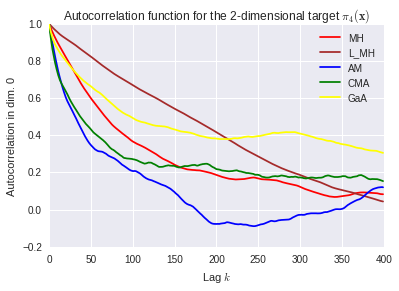

In [34]:
compare_autocorrelations(samplers_data=SAMPLERS_DATA, dim=0)